# AT & T

In [1]:
#%pip install tensorflow

In [2]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pathlib 
import pandas as pd 
import os
import io
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import json

In [4]:
print(tf.__version__)

2.11.0


## 1. Importation data

In [5]:
os.listdir()

['01-AT&T_spam_detector.ipynb',
 'AvgPooling_binary_20221229_history.json',
 'GRU_20221229_history.json',
 'LSTM_20221229_history.json',
 'NLP analysis.ipynb',
 'NLP_analysis_VF.ipynb',
 'old',
 'RNN_binary_20221229_history.json',
 'spam.csv']

In [6]:
train_df = pd.read_csv("spam.csv", encoding='latin-1')
train_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
train_set = train_df.loc[:, ["v1", "v2"]]
display(train_set.head())
train_set.shape

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


(5572, 2)

In [8]:
# balanced classes?
train_set["v1"].value_counts()
# not balanced class, should include class weight on model

ham     4825
spam     747
Name: v1, dtype: int64

In [9]:
train_set["target"] = train_set["v1"].apply(lambda x : 1 if x == "ham" else 0)
train_set.head(3)

,v1,v2,target
0,ham,"Go until jurong point, crazy.. Available only ...",1
1,ham,Ok lar... Joking wif u oni...,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0


In [10]:
# class frequency
class_spam = pd.DataFrame(train_set["target"].value_counts())
class_spam.sort_index(inplace=True)
class_weight = {v: (1 / class_spam.loc[v,"target"]) / 2 * class_spam["target"].sum() for v in class_spam.index}
class_weight

{0: 3.72958500669344, 1: 0.5774093264248704}

In [11]:
class_spam.index

Int64Index([0, 1], dtype='int64')

## 2. Preprocessing train dataset

#### importation library

In [12]:
#%pip install spacy

In [13]:
#!python -m spacy download en_core_web_md

### 2.1 Text encoding

In [14]:
import spacy
nlp = spacy.load('en_core_web_md')

In [15]:
from spacy.lang.en.stop_words import STOP_WORDS

In [16]:
# text encoding
train_set["text_clean"] = train_set["v2"].apply(lambda x : ''.join(ch for ch in x if ch.isalnum() or ch==" "))
train_set["text_clean"] = train_set["text_clean"].apply(lambda x: x.replace("  "," ").lower().strip())
train_set["text_clean"] = train_set["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

train_set.head()

,v1,v2,target,text_clean
0,ham,"Go until jurong point, crazy.. Available only ...",1,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,1,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,1,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",1,nah think usf live


### 2.2 Tensor slices

In [17]:
token = tf.keras.preprocessing.text.Tokenizer()

In [18]:
token.fit_on_texts(train_set["text_clean"])
train_set["text_encoded"] = token.texts_to_sequences(train_set["text_clean"])
train_set.head(10)

,v1,v2,target,text_clean,text_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",1,jurong point crazy available bugis n great wor...,"[3626, 229, 443, 460, 941, 35, 50, 203, 942, 7..."
1,ham,Ok lar... Joking wif u oni...,1,ok lar joke wif u oni,"[9, 193, 461, 288, 1, 1452]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0,free entry 2 wkly comp win fa cup final tkts 2...,"[12, 299, 3, 532, 661, 33, 1453, 845, 419, 145..."
3,ham,U dun say so early hor... U c already then say...,1,u dun early hor u c,"[1, 124, 149, 2372, 1, 83]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",1,nah think usf live,"[704, 22, 662, 130]"
5,spam,FreeMsg Hey there darling it's been 3 week's n...,0,freemsg hey darle 3 week word d like fun tb ok...,"[607, 55, 1773, 93, 38, 121, 32, 14, 236, 1456..."
6,ham,Even my brother is not like to speak with me. ...,1,brother like speak treat like aids patent,"[388, 14, 158, 403, 14, 3629, 3630]"
7,ham,As per your request 'Melle Melle (Oru Minnamin...,1,request melle melle oru minnaminunginte nurung...,"[663, 1072, 1072, 1457, 1774, 1775, 1776, 356,..."
8,spam,WINNER!! As a valued network customer you have...,0,winner value network customer select receivea ...,"[462, 444, 238, 116, 252, 2374, 944, 69, 707, ..."
9,spam,Had your mobile 11 months or more? U R entitle...,0,mobile 11 month u r entitle update late colour...,"[34, 768, 170, 1, 27, 846, 326, 68, 357, 34, 2..."


In [19]:
train_set["len_text"] = train_set["text_encoded"].apply(lambda x: len(x))
train_set = train_set[train_set["len_text"]!=0]
display(train_set.head(10))
train_set.shape

,v1,v2,target,text_clean,text_encoded,len_text
0,ham,"Go until jurong point, crazy.. Available only ...",1,jurong point crazy available bugis n great wor...,"[3626, 229, 443, 460, 941, 35, 50, 203, 942, 7...",14
1,ham,Ok lar... Joking wif u oni...,1,ok lar joke wif u oni,"[9, 193, 461, 288, 1, 1452]",6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0,free entry 2 wkly comp win fa cup final tkts 2...,"[12, 299, 3, 532, 661, 33, 1453, 845, 419, 145...",22
3,ham,U dun say so early hor... U c already then say...,1,u dun early hor u c,"[1, 124, 149, 2372, 1, 83]",6
4,ham,"Nah I don't think he goes to usf, he lives aro...",1,nah think usf live,"[704, 22, 662, 130]",4
5,spam,FreeMsg Hey there darling it's been 3 week's n...,0,freemsg hey darle 3 week word d like fun tb ok...,"[607, 55, 1773, 93, 38, 121, 32, 14, 236, 1456...",17
6,ham,Even my brother is not like to speak with me. ...,1,brother like speak treat like aids patent,"[388, 14, 158, 403, 14, 3629, 3630]",7
7,ham,As per your request 'Melle Melle (Oru Minnamin...,1,request melle melle oru minnaminunginte nurung...,"[663, 1072, 1072, 1457, 1774, 1775, 1776, 356,...",15
8,spam,WINNER!! As a valued network customer you have...,0,winner value network customer select receivea ...,"[462, 444, 238, 116, 252, 2374, 944, 69, 707, ...",17
9,spam,Had your mobile 11 months or more? U R entitle...,0,mobile 11 month u r entitle update late colour...,"[34, 768, 170, 1, 27, 846, 326, 68, 357, 34, 2...",17


(5555, 6)

In [20]:
train_set["len_text"].max()

72

In [21]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_set["text_encoded"], padding="post")

In [22]:
train_pad.shape

(5555, 72)

### 2.3 Train val sets

In [23]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(train_pad, train_set["target"],
                                              test_size=0.3, random_state=0,
                                              stratify=train_set["target"])

In [24]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [25]:
train_data = train.shuffle(len(train)).batch(64)
val_data = val.shuffle(len(val)).batch(64)

In [26]:
for x, y in train_data.take(1):
  print('x:',x)
  print('y:',y)

x: tf.Tensor(
[[  93  154   34 ...    0    0    0]
 [ 102 4523  285 ...    0    0    0]
 [ 269   40   43 ...    0    0    0]
 ...
 [  58  791   16 ...    0    0    0]
 [  87    4  168 ...    0    0    0]
 [  45  132  125 ...    0    0    0]], shape=(64, 72), dtype=int32)
y: tf.Tensor(
[0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1], shape=(64,), dtype=int64)


## 3. Modelling

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalAveragePooling1D, GRU, SimpleRNN, LSTM

In [28]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

- used variables

In [29]:
embedding_dim = 64
vocab_size = len(token.word_counts)

In [30]:
vocab_size

8218

### 3.1 Model 1: global average embedding

In [31]:
modelGAP = Sequential([
  Embedding(vocab_size+1, embedding_dim, input_shape=[x.shape[1],], name="embedding"), 
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dropout(0.6),
  Dense(2, activation="sigmoid") #better than Dense(2, activation="softmax")
])

In [32]:
modelGAP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 64)            526016    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 527,090
Trainable params: 527,090
Non-trainable params: 0
__________________________________________________

In [33]:
# model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
modelGAP.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [34]:
# model fitting
modelGAP.fit(
    train_data,
    validation_data=val_data,
    class_weight=class_weight,
    epochs=30)

Epoch 1/30
61/61 [==============================] - 3s 17ms/step - loss: 0.6908 - sparse_categorical_accuracy: 0.5882 - val_loss: 0.6773 - val_sparse_categorical_accuracy: 0.9466
Epoch 2/30
61/61 [==============================] - 1s 12ms/step - loss: 0.6736 - sparse_categorical_accuracy: 0.7767 - val_loss: 0.6487 - val_sparse_categorical_accuracy: 0.9772
Epoch 3/30
61/61 [==============================] - 1s 12ms/step - loss: 0.6184 - sparse_categorical_accuracy: 0.8724 - val_loss: 0.5730 - val_sparse_categorical_accuracy: 0.9772
Epoch 4/30
61/61 [==============================] - 1s 12ms/step - loss: 0.5070 - sparse_categorical_accuracy: 0.8835 - val_loss: 0.4092 - val_sparse_categorical_accuracy: 0.9814
Epoch 5/30
61/61 [==============================] - 1s 12ms/step - loss: 0.3742 - sparse_categorical_accuracy: 0.9180 - val_loss: 0.2423 - val_sparse_categorical_accuracy: 0.9814
Epoch 6/30
61/61 [==============================] - 1s 13ms/step - loss: 0.2866 - sparse_categorical_accu

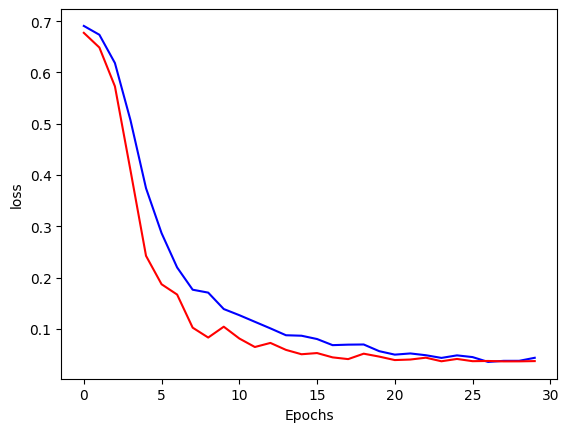

In [35]:
# plot model
# Visualization of the training process on the loss function 
plt.plot(modelGAP.history.history["loss"], color="b")
plt.plot(modelGAP.history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

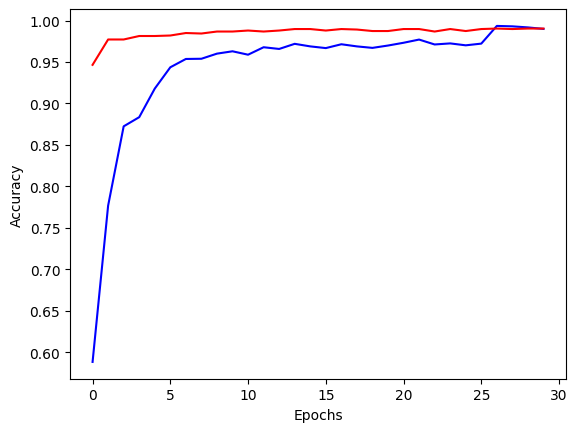

In [36]:
plt.plot(modelGAP.history.history["sparse_categorical_accuracy"], color="b")
plt.plot(modelGAP.history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [37]:
from sklearn.metrics import classification_report
yp_val = modelGAP.predict(xval)
print(classification_report(yval, yp_val.argmax(axis=1)))

53/53 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       224
           1       0.99      1.00      0.99      1443

    accuracy                           0.99      1667
   macro avg       0.99      0.97      0.98      1667
weighted avg       0.99      0.99      0.99      1667



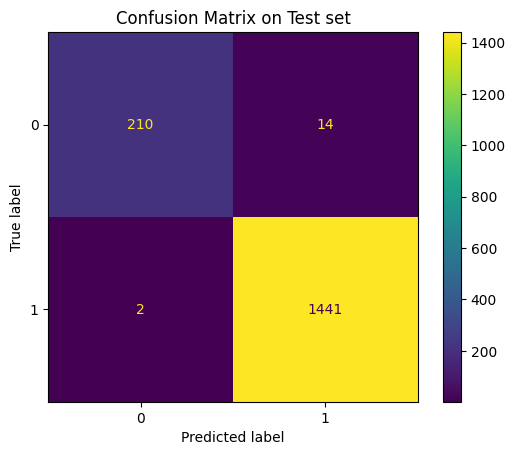

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

# plot
_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_predictions(yval, yp_val.argmax(axis=1), ax=ax)
plt.show()

In [39]:
# saving model
json.dump(modelGAP.history.history, open("AvgPooling_binary_history.json", 'w'))

### 3.2 Model 2: Simple RNN

In [40]:
modelRNN = Sequential([
  Embedding(vocab_size+1, embedding_dim, input_shape=[x.shape[1],], name="embedding"),
  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
  SimpleRNN(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'),
  Dropout(0.4),
  Dense(2, activation="sigmoid")
])

In [41]:
modelRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 64)            526016    
                                                                 
 simple_rnn (SimpleRNN)      (None, 72, 64)            8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 537,938
Trainable params: 537,938
Non-tr

In [42]:
# model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
modelRNN.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [43]:
# model fitting
modelRNN.fit(
    train_data,
    validation_data=val_data,
    class_weight=class_weight,
    epochs=10)

Epoch 1/10
61/61 [==============================] - 8s 54ms/step - loss: 0.5771 - sparse_categorical_accuracy: 0.7945 - val_loss: 0.5231 - val_sparse_categorical_accuracy: 0.7726
Epoch 2/10
61/61 [==============================] - 3s 46ms/step - loss: 0.4771 - sparse_categorical_accuracy: 0.8369 - val_loss: 0.4476 - val_sparse_categorical_accuracy: 0.8242
Epoch 3/10
61/61 [==============================] - 3s 47ms/step - loss: 0.3763 - sparse_categorical_accuracy: 0.9025 - val_loss: 0.3367 - val_sparse_categorical_accuracy: 0.8866
Epoch 4/10
61/61 [==============================] - 3s 50ms/step - loss: 0.2908 - sparse_categorical_accuracy: 0.9465 - val_loss: 0.3237 - val_sparse_categorical_accuracy: 0.8722
Epoch 5/10
61/61 [==============================] - 3s 45ms/step - loss: 0.2087 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.1784 - val_sparse_categorical_accuracy: 0.9496
Epoch 6/10
61/61 [==============================] - 3s 48ms/step - loss: 0.1551 - sparse_categorical_accu

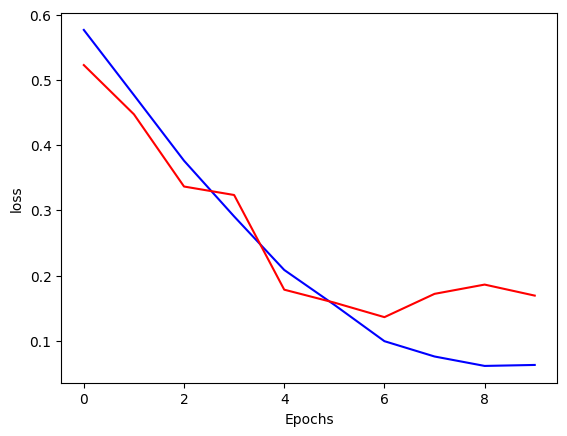

In [44]:
# plot model
# Visualization of the training process on the loss function 
plt.plot(modelRNN.history.history["loss"], color="b")
plt.plot(modelRNN.history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

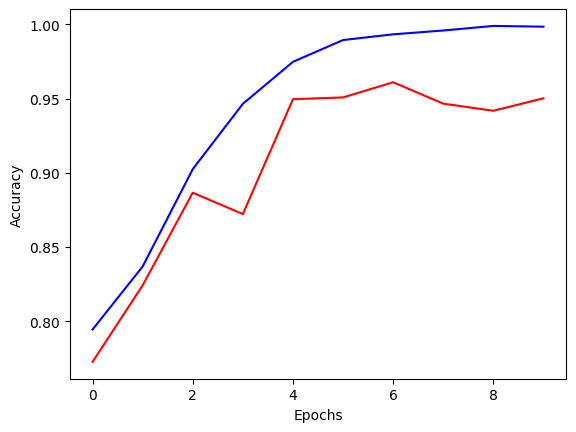

In [45]:
plt.plot(modelRNN.history.history["sparse_categorical_accuracy"], color="b")
plt.plot(modelRNN.history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [46]:
# saving model
json.dump(modelRNN.history.history, open("RNN_binary_history.json", 'w'))

### 3.3 Model 3: GRU

In [47]:
# model architecture
modelGRU = Sequential([
  Embedding(vocab_size+1, embedding_dim, input_shape=[x.shape[1],], name="embedding"),
  GRU(units=64, return_sequences=True),
  GRU(units=32, return_sequences=False),
  Dense(16, activation='relu'),
  Dropout(0.4),
  Dense(2, activation="sigmoid") # better than Dense(2, activation="softmax")
])

In [48]:
modelGRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 64)            526016    
                                                                 
 gru (GRU)                   (None, 72, 64)            24960     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 560,946
Trainable params: 560,946
Non-tr

In [49]:
# model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
modelGRU.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [50]:
# model fitting
modelGRU.fit(
    train_data,
    validation_data=val_data,
    class_weight=class_weight,
    epochs=20)

Epoch 1/20
61/61 [==============================] - 15s 114ms/step - loss: 0.6945 - sparse_categorical_accuracy: 0.6780 - val_loss: 0.6875 - val_sparse_categorical_accuracy: 0.8656
Epoch 2/20
61/61 [==============================] - 6s 101ms/step - loss: 0.6941 - sparse_categorical_accuracy: 0.6595 - val_loss: 0.6885 - val_sparse_categorical_accuracy: 0.8656
Epoch 3/20
61/61 [==============================] - 6s 99ms/step - loss: 0.6944 - sparse_categorical_accuracy: 0.6631 - val_loss: 0.6877 - val_sparse_categorical_accuracy: 0.8656
Epoch 4/20
61/61 [==============================] - 6s 100ms/step - loss: 0.6941 - sparse_categorical_accuracy: 0.5154 - val_loss: 0.6900 - val_sparse_categorical_accuracy: 0.8656
Epoch 5/20
61/61 [==============================] - 6s 99ms/step - loss: 0.6946 - sparse_categorical_accuracy: 0.5877 - val_loss: 0.6922 - val_sparse_categorical_accuracy: 0.8656
Epoch 6/20
61/61 [==============================] - 6s 98ms/step - loss: 0.6942 - sparse_categorical_

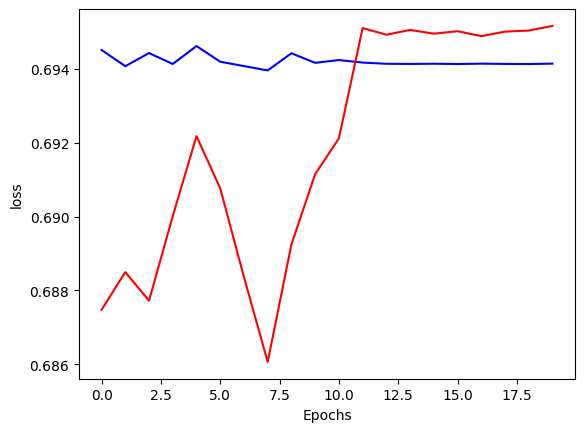

In [51]:
plt.plot(modelGRU.history.history["loss"], color="b")
plt.plot(modelGRU.history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

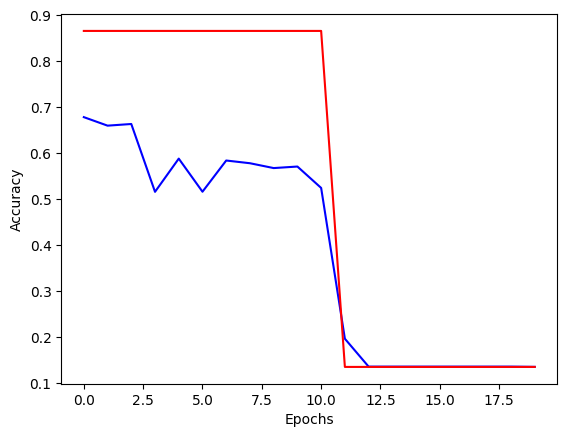

In [52]:
plt.plot(modelGRU.history.history["sparse_categorical_accuracy"], color="b")
plt.plot(modelGRU.history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
# saving model
json.dump(modelGRU.history.history, open("GRU_history.json", 'w'))

### 3.4 Model 4: LSTM

In [54]:
# model architecture
modelLSTM = Sequential([
  Embedding(vocab_size+1, embedding_dim, input_shape=[x.shape[1],], name="embedding"),
  LSTM(units=64, return_sequences=True),
  LSTM(units=32, return_sequences=False),
  Dense(16, activation='relu'),
  Dropout(0.4),
  Dense(2, activation="sigmoid") # better than Dense(2, activation="softmax")
])

In [55]:
modelLSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 64)            526016    
                                                                 
 lstm (LSTM)                 (None, 72, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 34        
                                                                 
Total params: 572,018
Trainable params: 572,018
Non-tr

In [56]:
# model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
modelLSTM.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [57]:
# model fitting
modelLSTM.fit(
    train_data,
    validation_data=val_data,
    class_weight=class_weight,
    epochs=20)

Epoch 1/20
61/61 [==============================] - 15s 148ms/step - loss: 0.6949 - sparse_categorical_accuracy: 0.6368 - val_loss: 0.6997 - val_sparse_categorical_accuracy: 0.1344
Epoch 2/20
61/61 [==============================] - 8s 125ms/step - loss: 0.6944 - sparse_categorical_accuracy: 0.5270 - val_loss: 0.6953 - val_sparse_categorical_accuracy: 0.1344
Epoch 3/20
61/61 [==============================] - 8s 126ms/step - loss: 0.6942 - sparse_categorical_accuracy: 0.2109 - val_loss: 0.6944 - val_sparse_categorical_accuracy: 0.1344
Epoch 4/20
61/61 [==============================] - 8s 124ms/step - loss: 0.6942 - sparse_categorical_accuracy: 0.5682 - val_loss: 0.6804 - val_sparse_categorical_accuracy: 0.8656
Epoch 5/20
61/61 [==============================] - 8s 124ms/step - loss: 0.6945 - sparse_categorical_accuracy: 0.3843 - val_loss: 0.6965 - val_sparse_categorical_accuracy: 0.1344
Epoch 6/20
61/61 [==============================] - 7s 123ms/step - loss: 0.6942 - sparse_categoric

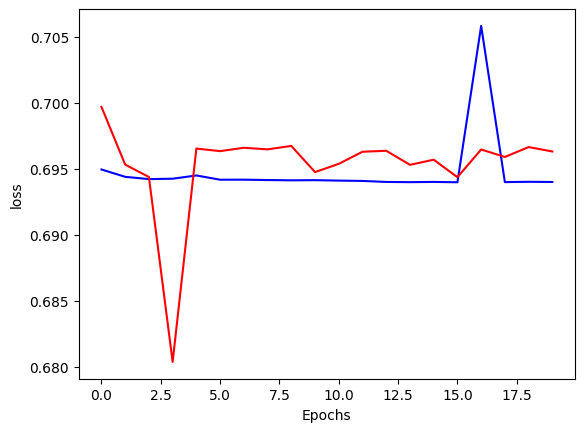

In [58]:
plt.plot(modelLSTM.history.history["loss"], color="b")
plt.plot(modelLSTM.history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

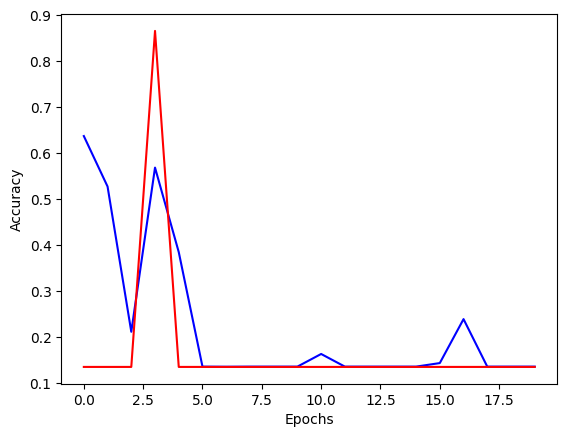

In [59]:
plt.plot(modelLSTM.history.history["sparse_categorical_accuracy"], color="b")
plt.plot(modelLSTM.history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [60]:
# saving model
json.dump(modelLSTM.history.history, open("LSTM_history.json", 'w'))